In [ ]:
import os
import shutil
from tqdm import tqdm
from random import shuffle
import cv2
import numpy as np

# Model Training

In [ ]:
training_file_path = '/content/drive/MyDrive/ML Project/Gerosh/training.npy'
testing_file_path = '/content/drive/MyDrive/ML Project/Gerosh/testing.npy'

training_data = np.load(training_file_path,allow_pickle=True)
testing_data = np.load(testing_file_path,allow_pickle=True)


In [ ]:
IMG_SIZE=128

def load_data():
  X_train=np.array([x[0] for x in training_data]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
  Y_train=np.array([y[1] for y in training_data])

  X_test=np.array([x[0] for x in testing_data]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
  Y_test=np.array([y[1] for y in testing_data])

  return (X_train,Y_train),(X_test,Y_test)

In [ ]:
class_names=['Normal','Covid-19']

def show_some_samples(x,y,p):
    indices = np.random.choice(range(len(x)), 10, replace=False)

    x = x[indices] 
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i].reshape(128,128), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

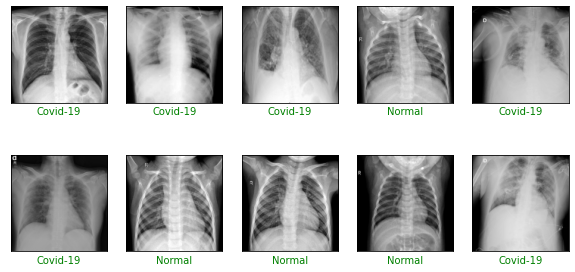

In [ ]:
(X_train,Y_train),(X_test,Y_test)=load_data()

show_some_samples(X_train,Y_train,Y_train)

# Build Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,Activation,MaxPooling2D, AveragePooling2D
from keras.layers import Concatenate
from keras import Input
from keras.callbacks import ModelCheckpoint,TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [ ]:
from matplotlib import pyplot as plt
import cv2
from PIL import Image
%matplotlib inline

print('Using Tensorflow', tf.__version__)

%load_ext tensorboard
!rm -rf ./logs/

Using Tensorflow 2.7.0


In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 40
BS = 32

#Rescale test and train data
(X_train,Y_train),(X_test,Y_test)=load_data()
X_train=X_train/255
X_test=X_test/255

# construct the training image generator for data augmentation
aug = ImageDataGenerator( 
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

## This model is made from scratch 

In [ ]:
input_shape = X_train.shape[1:]
inp = Input(shape = input_shape)

convs=[]

parrallel_kernels=[3,5]

for k in range(len(parrallel_kernels)):

    conv = Conv2D(128, parrallel_kernels[k],padding='same',activation='relu',input_shape=input_shape,strides=1)(inp)
    convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inputs=inp, outputs=out)

model = Sequential()
model.add(conv_model)

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(AveragePooling2D(pool_size=(4, 4)))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(2,input_dim=128,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 128, 128, 256)     4608      
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 64)      147520    
                                                                 
 activation_2 (Activation)   (None, 126, 126, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 32)        18464     
                                                                 
 activation_3 (Activation)   (None, 61, 61, 32)        0         
                                                      

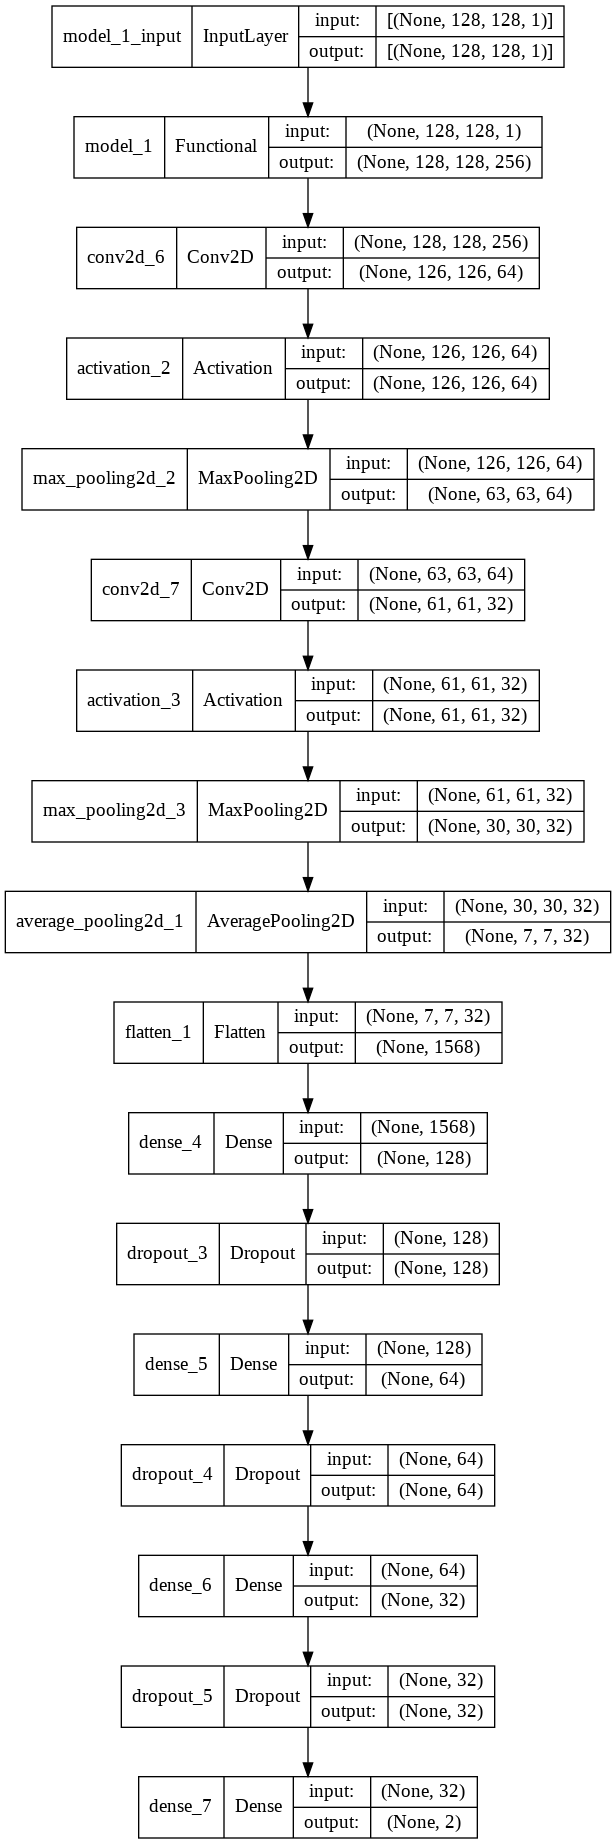

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
NAME = "128*128_Model_120ep_PConvd2"
log_dir = f"/content/drive/MyDrive/ML Project/LOGS/{NAME}"
tensorboard_callback = TensorBoard(log_dir=log_dir)

In [ ]:
filename = '/content/drive/MyDrive/ML Project/128_size_models/Weights/' + 'model2_CP2.model'
checkpoint = ModelCheckpoint(filename,monitor='val_loss',verbose=0,save_best_only=True,mode='min')

In [ ]:
filename

'/content/drive/MyDrive/ML Project/Gerosh/Weights/model2_CP2.model'

In [ ]:
# load previous model to train it more
model_file_path = '/content/drive/MyDrive/ML Project/128_size_models/model_128_CP2_80ep.h5'
model = load_model(model_file_path)

In [ ]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

with tf.device('/device:GPU:0'):
  history=model.fit(aug.flow(X_train, Y_train, batch_size=BS),
    steps_per_epoch=len(X_train)//BS,
    epochs=40,
    callbacks=[tensorboard_callback],
    validation_data=(X_test, Y_test),
    validation_steps=len(X_test)//BS)

Epoch 1/40
62/62 [==============================] - 55s 284ms/step - loss: 0.0700 - accuracy: 0.9756 - val_loss: 0.0652 - val_accuracy: 0.9903
Epoch 2/40
62/62 [==============================] - 17s 279ms/step - loss: 0.0769 - accuracy: 0.9771 - val_loss: 0.0757 - val_accuracy: 0.9807
Epoch 3/40
62/62 [==============================] - 17s 280ms/step - loss: 0.0739 - accuracy: 0.9751 - val_loss: 0.0495 - val_accuracy: 0.9855
Epoch 4/40
62/62 [==============================] - 17s 270ms/step - loss: 0.0773 - accuracy: 0.9797 - val_loss: 0.0536 - val_accuracy: 0.9855
Epoch 5/40
62/62 [==============================] - 17s 269ms/step - loss: 0.0672 - accuracy: 0.9787 - val_loss: 0.0590 - val_accuracy: 0.9855
Epoch 6/40
62/62 [==============================] - 17s 270ms/step - loss: 0.1076 - accuracy: 0.9741 - val_loss: 0.0921 - val_accuracy: 0.9758
Epoch 7/40
62/62 [==============================] - 17s 279ms/step - loss: 0.0745 - accuracy: 0.9792 - val_loss: 0.0615 - val_accuracy: 0.9855

In [ ]:
%reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir "/content/drive/MyDrive/ML Project/LOGS"

In [ ]:
len(model.layers)

16

In [ ]:
print(model.evaluate(X_test,Y_test))

7/7 [==============================] - 1s 95ms/step - loss: 0.0495 - accuracy: 0.9903
[0.049468476325273514, 0.990338146686554]


In [ ]:
from sklearn.metrics import classification_report
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(Y_test.argmax(axis=1), predIdxs,
	target_names=['Normal','Covid-19']))

[INFO] evaluating network...
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       145
    Covid-19       1.00      0.97      0.98        62

    accuracy                           0.99       207
   macro avg       0.99      0.98      0.99       207
weighted avg       0.99      0.99      0.99       207



In [ ]:
## Model Save
model.save('/content/drive/MyDrive/ML Project/128_size_models/model_128_CP2_120ep.h5')

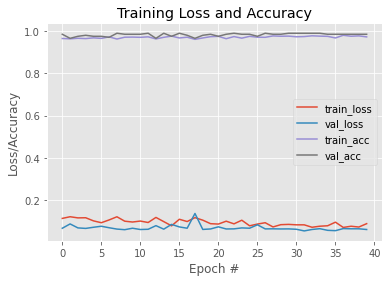

In [ ]:
# plot the training loss and accuracy
H=history
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig('plot.png')

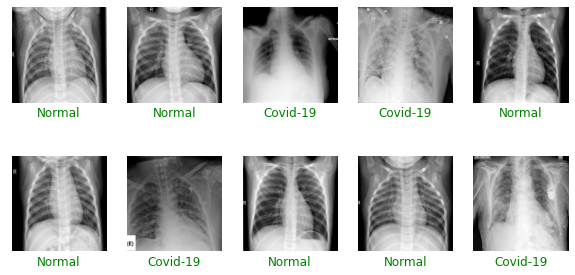

In [ ]:
preds=model.predict(X_test,batch_size=BS)
show_some_samples(X_test,Y_test,preds)

In [ ]:
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/ML Project/128_size_models/ML Project.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/ML Project/128_size_models/ML Project.ipynb to html
[NbConvertApp] Writing 778117 bytes to /content/drive/MyDrive/ML Project/128_size_models/ML Project.html
